In [0]:
import os
import random
from matplotlib import image
from matplotlib import pyplot as plt
from skimage import color
import pickle
import seaborn as sn
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
%matplotlib inline

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Process data

In [0]:
path = "drive/My Drive/School/Illinois/2019/stat542/group-project/542"

In [0]:
pickle_file = "drive/My Drive/School/Illinois/2019/stat542/group-project/images.pickle"

In [0]:
label_map = {'benign': 0, 'malignant': 1}

In [0]:
def save_images_to_disk(images, pickle_file):
  with open(pickle_file, 'wb') as handle:
    pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
def load_images_from_disk(pickle_file):
  try:
    with open(pickle_file, 'rb') as handle:
      return pickle.load(handle)
  except:
      return None

In [0]:
def image_to_array(image_path):
  size = (32,32)
  image_data = io.imread(image_path)
  return np.array(resize(image_data, size, anti_aliasing=True))

In [0]:
def load_images(images_path, pickle_file):
  saved_images = load_images_from_disk(pickle_file)

  if saved_images:
    return saved_images
  else:
    label_images = {}
    labels = os.listdir(images_path)
    for label in labels:
      images = os.listdir(f"{images_path}/{label}")
      label_images[label] = [image_to_array(f"{images_path}/{label}/{image}") for image in  tqdm(images)]
  
  save_images_to_disk(images, pickle_file)
  return label_images

In [0]:
def show_sample(images):
  samples_images = []
  for label in images:
    image = images[label][0]
    pyplot.figure()
    pyplot.title(label)
    pyplot.imshow(image)

  pyplot.show()

In [0]:
def prepare_images_for_training(images):
  x = []
  y = []
  for label in images:
    for image in images[label]:
      x.append(image.reshape(-1))
      y.append(label_map[label])
  
  return np.array(x),np.array(y)

In [0]:
images = load_images(path, pickle_file)

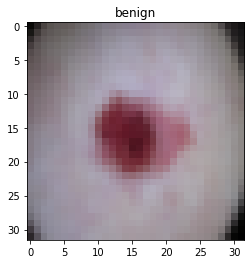

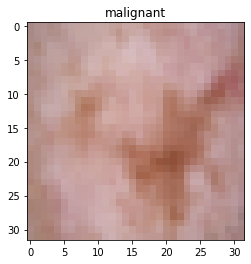

In [67]:
show_sample(images)

In [0]:
x, y = prepare_images_for_training(images)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=11)

## Train model 1: Support Vector Machine

In [0]:
clf = SVC(gamma='scale').fit(X_train, y_train)

In [158]:
clf.score(X_test, y_test)

0.696969696969697

In [0]:
y_pred = clf.predict(X_test)

In [160]:
f"Base accuracy {accuracy_score(y_test, y_pred)}"

'Base accuracy 0.696969696969697'

### Let's try to find the best set of parameters with cross validation

In [0]:
clf = SVC()

In [0]:
param_grid = [{"kernel": ["linear", "poly", "rbf", "sigmoid"]}]

In [109]:
search = GridSearchCV(clf, param_grid, cv=10, verbose=2, n_jobs=-1).fit(x, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [110]:
search.best_score_

0.6733333333333333

In [111]:
search.best_params_

{'kernel': 'rbf'}

In [0]:
best_clf = search.best_estimator_

### Accuracy results

In [117]:
best_clf.score(X_test, y_test)

0.6666666666666666

In [0]:
y_pred = best_clf.predict(X_test)

In [0]:
matrix = confusion_matrix(y_test, y_pred)

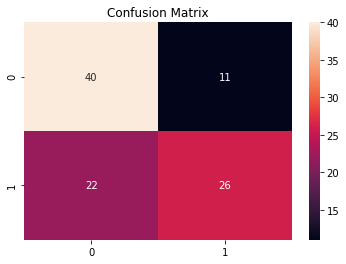

In [121]:
sn.heatmap(matrix, annot=True)
plt.title('Confusion Matrix')
plt.show()

As we can see, we got 40 true negatives, 11 false positives, 22 false negatives, and 26 true positives. 

In [0]:
accuracy = accuracy_score(y_test, y_pred)

In [0]:
recall = recall_score(y_test, y_pred)

In [0]:
specificity = 40 / (40 + 11)

In [126]:
f"Overall, we the SVM model achieved an accuracy score of {accuracy} with a {recall} recall score."

'Overall, we the SVM model achieved an accuracy score of 0.6666666666666666 with a 0.5416666666666666 recall score.'

In [127]:
f"We also achived a specificity of {specificity} that measures how often is the prediction correct if the actual value is negative."

'We also achived a specificity of 0.7843137254901961 that measures how often is the prediction correct if the actual value is negative.'

## Train model 2: Logistic Model

In [128]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [129]:
clf.score(X_test, y_test)

0.7272727272727273

In [0]:
y_pred = clf.predict(X_test)

In [161]:
f"Base accuracy {accuracy_score(y_test, y_pred)}"

'Base accuracy 0.696969696969697'

### Let's try to find the best set of parameters with cross validation

In [0]:
clf = LogisticRegression(random_state=0)

In [0]:
param_grid = {'penalty': ['l1', 'l2']}

In [133]:
search = GridSearchCV(clf, param_grid, cv=10, verbose=2, n_jobs=-1).fit(x, y)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [134]:
search.best_score_

0.69

In [135]:
search.best_params_

{'penalty': 'l1'}

In [0]:
best_clf = search.best_estimator_

In [137]:
best_clf.score(X_test, y_test)

0.797979797979798

In [0]:
y_pred = best_clf.predict(X_test)

In [0]:
matrix = confusion_matrix(y_test, y_pred)

In [0]:
[tn,fp,fn,tp] = matrix.flatten()

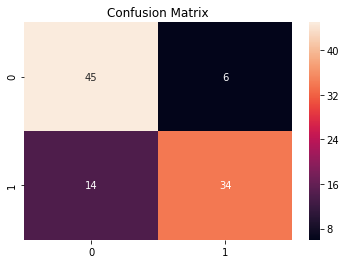

In [140]:
sn.heatmap(matrix, annot=True)
plt.title('Confusion Matrix')
plt.show()

In [154]:
f"As we can see, we got {tn} true negatives, {fp} false positives, {fn} false negatives, and {tp} true positives. "

'As we can see, we got 45 true negatives, 6 false positives, 14 false negatives, and 34 true positives. '

In [0]:
accuracy = accuracy_score(y_test, y_pred)

In [0]:
recall = recall_score(y_test, y_pred)

In [0]:
specificity = tn / (tn + fp)

In [182]:
f"Overall, we the logistic regression model achieved an accuracy score of {accuracy} with a {recall} recall score."

'Overall, we the logistic regression model achieved an accuracy score of 0.797979797979798 with a 0.7083333333333334 recall score.'

In [153]:
f"We also achived a specificity of {specificity} that measures how often is the prediction correct if the actual value is negative."

'We also achived a specificity of 0.8823529411764706 that measures how often is the prediction correct if the actual value is negative.'

## Train model 3: Tree

In [0]:
clf = GradientBoostingClassifier().fit(X_train, y_train)

In [164]:
clf.score(X_test, y_test)

0.6767676767676768

In [0]:
y_pred = clf.predict(X_test)

In [166]:
f"Base accuracy {accuracy_score(y_test, y_pred)}"

'Base accuracy 0.6767676767676768'

### Let's try to find the best set of parameters with cross validation

In [0]:
clf = GradientBoostingClassifier()

In [0]:
param_grid = {'learning_rate': [.5, 1,1.5], 'n_estimators': [100, 200, 300], 'max_depth': [3,5,8]}

In [171]:
search = GridSearchCV(clf, param_grid, cv=4, verbose=3, n_jobs=-1).fit(x, y)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [172]:
search.best_score_

0.6933333333333334

In [173]:
search.best_params_

{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 300}

In [0]:
best_clf = search.best_estimator_

In [181]:
best_clf.score(X_test, y_test)

1.0

In [0]:
y_pred = best_clf.predict(X_test)

In [0]:
matrix = confusion_matrix(y_test, y_pred)

In [0]:
[tn,fp,fn,tp] = matrix.flatten()

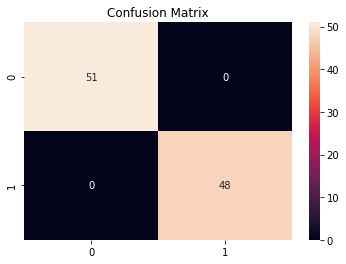

In [179]:
sn.heatmap(matrix, annot=True)
plt.title('Confusion Matrix')
plt.show()

In [0]:
f"As we can see, we got {tn} true negatives, {fp} false positives, {fn} false negatives, and {tp} true positives. "

'As we can see, we got 45 true negatives, 6 false positives, 14 false negatives, and 34 true positives. '

In [0]:
accuracy = accuracy_score(y_test, y_pred)

In [0]:
recall = recall_score(y_test, y_pred)

In [0]:
specificity = tn / (tn + fp)

In [0]:
f"Overall, we the tree model achieved an accuracy score of {accuracy} with a {recall} recall score."

'Overall, we the SVM model achieved an accuracy score of 0.797979797979798 with a 0.7083333333333334 recall score.'

In [0]:
f"We also achived a specificity of {specificity} that measures how often is the prediction correct if the actual value is negative."

'We also achived a specificity of 0.8823529411764706 that measures how often is the prediction correct if the actual value is negative.'